# Training the CNN

In this tutorial we are going to train the CNN using the patches extracted in the previous demo ([link](patches-extraction-rgb-CC-347.ipynb)). The CNN architecture we are using is illustrated in the figure below. 

<img src="../Figures/arhcitecture_unet_mod.png" alt="Drawing" style="width: 500px;"/>

The goal of this tutorial is:

 - Illustarte how to train a CNN for image segmentation.

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import nibabel as nib
import os
import glob
import sys
import random
import time

from keras.callbacks import ModelCheckpoint, EarlyStopping

MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
import ipt_utils
import cnn_utils

Using TensorFlow backend.


## Loading patches 

In [2]:
#Set this path accordingly
patches_path = "/media/roberto/DATA/Patches-CC347"

#Listing patches (original and masks)
orig_patches = np.array([f for f in os.listdir(patches_path) if f.endswith("_orig.npy")])
staple_patches = np.array([f.split("_orig")[0] + "_staple.npy" for f in orig_patches])

#Shuffling patches
indexes = np.arange(orig_patches.size,dtype = int)
np.random.shuffle(indexes)
orig_patches = orig_patches[indexes]
staple_patches = staple_patches[indexes]

#This info comes from the part I demo
patch_size = (64,64)
max_value = 1000.0
nsubjects = len(orig_patches)
nslices = 120
npatches = 5

#Pre-allocating patches' array
patches = np.zeros((nslices*npatches*nsubjects,patch_size[0],patch_size[1],3),dtype = np.float32)
labels = np.zeros((nslices*npatches*nsubjects,patch_size[0],patch_size[1],1),dtype = np.float32)

# Loading patches
counter = 0
step = nslices*npatches
for (ii,jj) in zip(orig_patches,staple_patches):
   aux_patches = np.load(os.path.join(patches_path,ii))
   aux_labels = np.load(os.path.join(patches_path,jj))[:,:,:,np.newaxis]
   patches[counter*step:(counter+1)*step] = aux_patches
   labels[counter*step:(counter+1)*step] = aux_labels
   counter+=1

patches /= max_value
#Patches info
print patches.shape
print patches.dtype
print labels.shape
print labels.dtype
print patches.mean()

(208200, 64, 64, 3)
float32
(208200, 64, 64, 1)
float32
0.170438


## Normalizing the patches

In [3]:
#Percentage of the data used for validation
val_perc = 0.3

# Train and validation split     
val = int(val_perc*nsubjects)*nslices*npatches        
train01 = patches[:-val]
labels01 = labels[:-val]        
val01 = patches[-val:]
labels_val01 = labels[-val:]

#Standardization        
mean = np.mean(train01)  
std = np.std(train01)
train01 -= mean
train01 /= std

val01-= mean
val01/= std
print "Train set"
print train01.shape
print "Validation set"
print val01.shape
print "Mean, std:"
print mean
print std
#Saving stats
np.save("../Data/ss_unet_cc347.npy",np.array([mean,std]))        

Train set
(145800, 64, 64, 3)
Validation set
(62400, 64, 64, 3)
Mean, std:
0.172028
0.140935


## Defining keras callbacks

In [4]:
# String used to save models after each epoch
model_name = "../Data/ss_unet_cc_347_best.hdf5"

# Early stopping callback to shut down training after
#10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_dice_coef',
                                       patience=3, 
                                       verbose=0, mode='max')

# Checkpoint callback to save model  along the epochs
checkpoint = ModelCheckpoint(model_name, mode = 'max', \
                             monitor='val_dice_coef',verbose=0,\
                             save_best_only=False, save_weights_only = True)
    

## Training the model

In [5]:
# Create model
model = cnn_utils.get_unet_mod(patch_size = (64,64),\
                               learning_rate = 1e-4,\
                               learning_decay = 5e-9)

hist = model.fit(train01,labels01,epochs=100,
                 batch_size = 64,verbose=1,
                 validation_data= (val01,labels_val01),
                 callbacks=[checkpoint,earlyStopping])

Train on 145800 samples, validate on 62400 samples
Epoch 1/100
145800/145800 [==============================] - 418s - loss: -0.8122 - dice_coef: 0.8122 - val_loss: -0.9707 - val_dice_coef: 0.9707
Epoch 2/100
145800/145800 [==============================] - 411s - loss: -0.9815 - dice_coef: 0.9815 - val_loss: -0.9827 - val_dice_coef: 0.9827
Epoch 3/100
145800/145800 [==============================] - 422s - loss: -0.9847 - dice_coef: 0.9847 - val_loss: -0.9851 - val_dice_coef: 0.9851
Epoch 4/100
145800/145800 [==============================] - 422s - loss: -0.9863 - dice_coef: 0.9863 - val_loss: -0.9854 - val_dice_coef: 0.9854
Epoch 5/100
145800/145800 [==============================] - 422s - loss: -0.9868 - dice_coef: 0.9868 - val_loss: -0.9859 - val_dice_coef: 0.9859
Epoch 6/100
145800/145800 [==============================] - 422s - loss: -0.9878 - dice_coef: 0.9878 - val_loss: -0.9855 - val_dice_coef: 0.9855
Epoch 7/100
145800/145800 [==============================] - 422s - loss:

## Plotting train and validation Dice coefficients

26


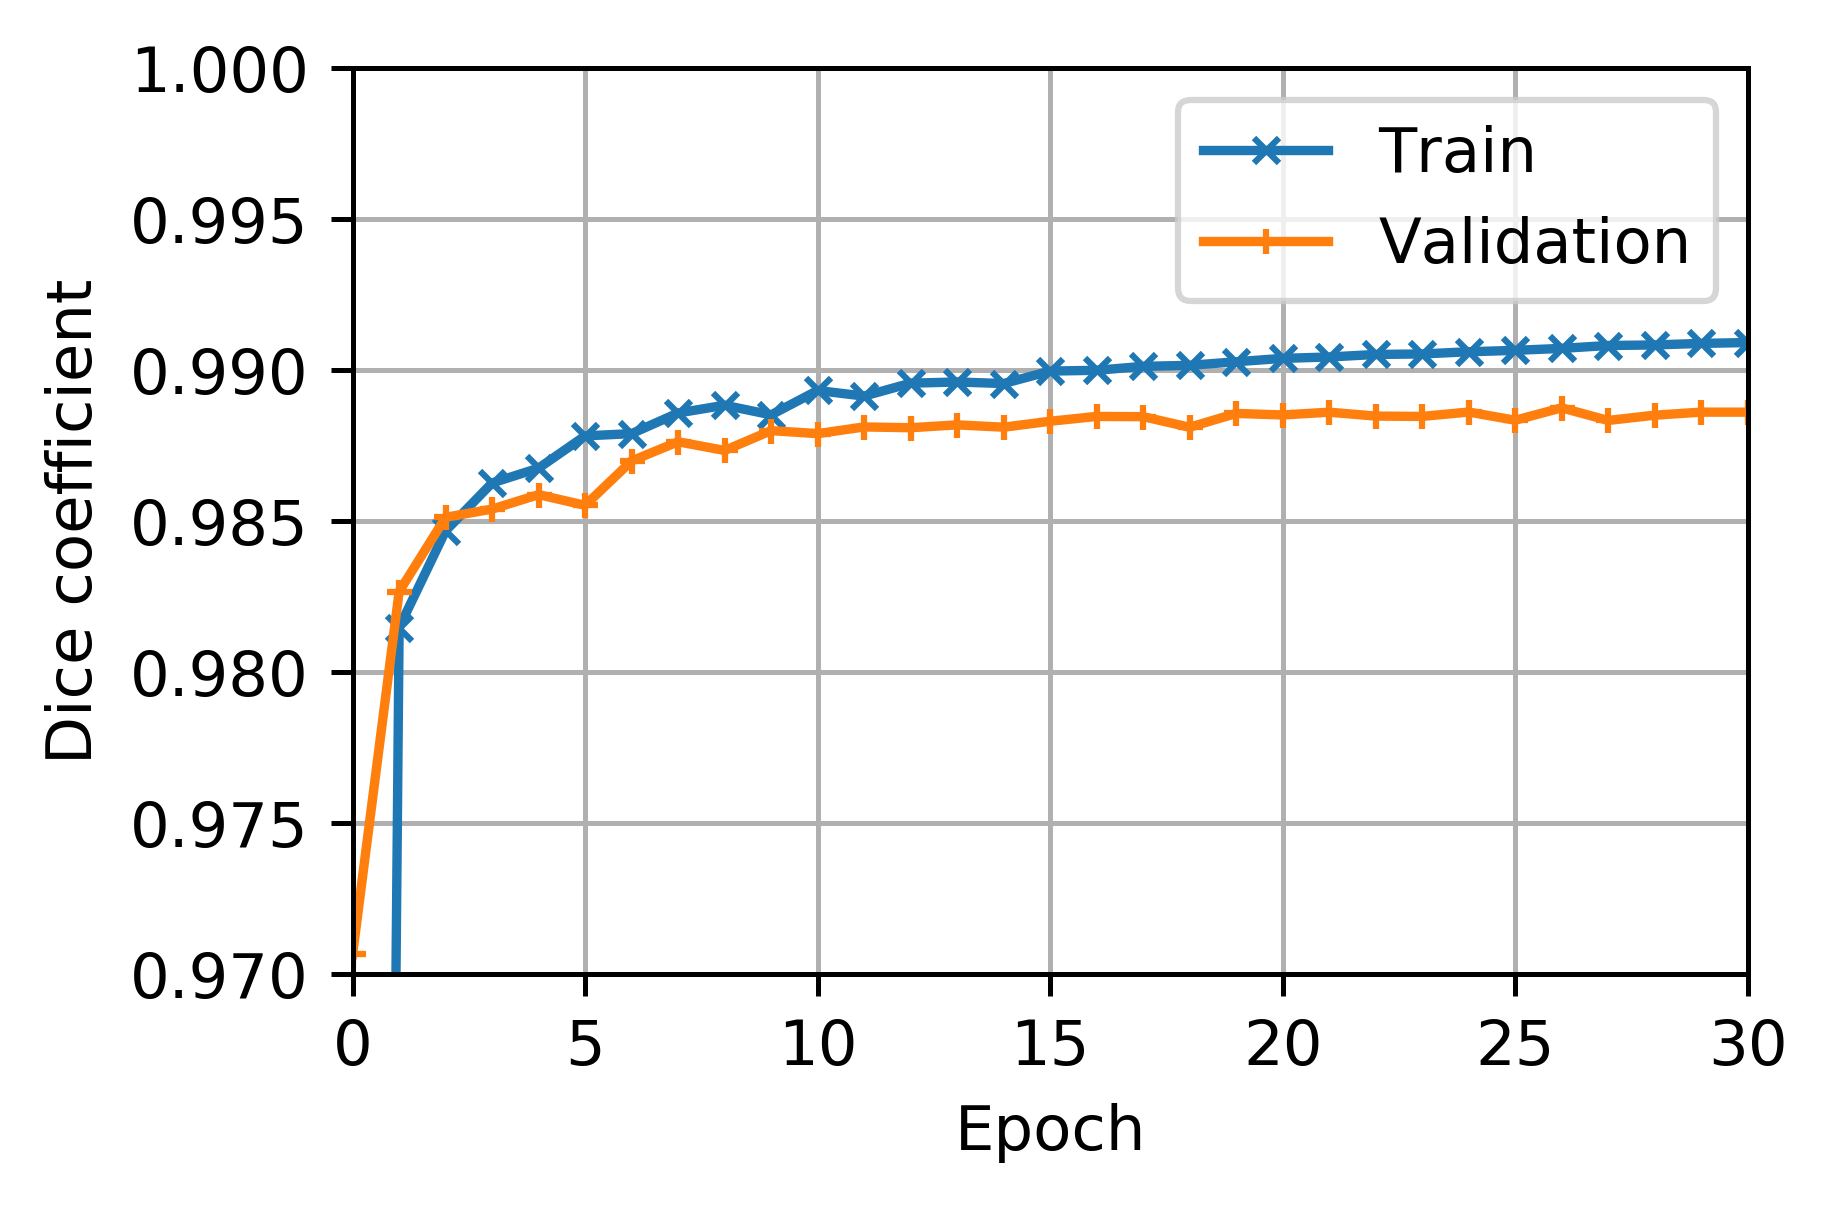

In [11]:
#Saving training history
np.save("../Data/loss_cc347.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_cc347.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
print val_loss.argmin()
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(-1*loss,'x-', markersize = 4,label = "Train")
plt.plot(-1*val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlim(0,30)
plt.ylim(0.97,1.0)
plt.xlabel("Epoch")
plt.ylabel("Dice coefficient")
plt.show()

## Activity suggestions

- Using a GPU computer train the network using data augmentation to see if the results improve.